# Third model, first analysis

This is our third pass at getting a model that includes all the volumes we need. It adds about 40 volumes in a British canon (nonusnorton), and more importantly does some manual correction of metadata in order to generate "contrast sets" that are dated as accurately as our hypothesis sets.

However, I don't expect results to change very much from the second model.

In [83]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math, random
from scipy.stats import pearsonr, zscore, ttest_ind
from statistics import mean, stdev
from math import sqrt
import statsmodels.api as sm

/Users/tunder/miniconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### get metadata

In order to analyze the data we will need a metadata table that includes information about volumes, including inferred biographical information about the author (age, gender, nationality) and columns that assign volumes to particular "hypothesis" and "contrast" sets.

In [36]:
meta = pd.read_csv('../supplement3/thirdmastermeta.tsv', sep = '\t', index_col = 'docid')
print(meta.shape)
meta.columns

(39784, 39)


Index(['allcopiesofwork', 'author', 'copiesin25yrs', 'earlyedition', 'imprint',
       'inferreddate', 'lastname', 'latestcomp', 'nationality', 'isusa',
       'actualgender', 'likelygender', 'title', 'authordate', 'birth', 'age',
       'recordid', 'best1821_1900', 'best1900_1950', 'best1950_1990',
       'anybest', 'best1821_1900contrast', 'best1900_1950contrast',
       'best1950_1990contrast', 'reviewed1850_1950',
       'reviewed1850_1950contrast', 'heath', 'heathcontrast', 'mostdiscussed',
       'mostdiscussedcontrast', 'usnorton', 'usnortoncontrast', 'nonusnorton',
       'nonusnortoncontrast', 'preregistered', 'preregisteredcontrast',
       'reviewed1965_1990', 'reviewed1965_1990contrast', 'toremove'],
      dtype='object')

### get data

Now the data itself. This is broken into a number of "summary files" because the processing that produced it had to be distributed across a cluster. (The entropy calculation is done by comparing individual volumes to each other, and when you've got 40k vols, the number of cross-comparisons becomes fairly large.)

So we first make a list of all the files we need ...

In [3]:
paths = glob.glob('../supp3results/*summary.tsv')
paths

['../supp3results/supp3_12000summary.tsv',
 '../supp3results/supp3_38000summary.tsv',
 '../supp3results/supp3_16000summary.tsv',
 '../supp3results/supp3_0summary.tsv',
 '../supp3results/supp3_8000summary.tsv',
 '../supp3results/supp3_28000summary.tsv',
 '../supp3results/supp3_26000summary.tsv',
 '../supp3results/supp3_22000summary.tsv',
 '../supp3results/supp3_2000summary.tsv',
 '../supp3results/supp3_6000summary.tsv',
 '../supp3results/supp3_32000summary.tsv',
 '../supp3results/supp3_36000summary.tsv',
 '../supp3results/supp3_18000summary.tsv',
 '../supp3results/supp3_20000summary.tsv',
 '../supp3results/supp3_24000summary.tsv',
 '../supp3results/supp3_34000summary.tsv',
 '../supp3results/supp3_30000summary.tsv',
 '../supp3results/supp3_4000summary.tsv',
 '../supp3results/supp3_14000summary.tsv',
 '../supp3results/supp3_10000summary.tsv']

... and then loop across the list, reading them in ... and finally concatenate the data frames.

In [4]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)

data = pd.concat(dfs, verify_integrity = True)
print(data.shape)

(39784, 27)


Thank god, the number of rows in metadata == number of rows in data!

### test hypotheses on raw data

There are lots of ways we can test our hypotheses, but first let's start simple. We'll just identify volumes in the hypothesis set, and those in a contrast set (matched as closely as practical to the hypothesis set in genre, nationality, and date). The [matching strategy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/) is a way of addressing confounding variables without some of the slipperiness of a complex regression.

Then we run a t test on resonance for each of these categories. 

I'm primarily going to measure resonance at the 25-year window, and use all the volumes. I consider the column ```resonance_1.0_25``` the most reliable, generalized test. But I will also test at the 5% level, to see how that differs.

In [43]:
def testahypothesis(hypothesis_cat, data, meta):
    contrast_cat = hypothesis_cat + 'contrast'
    
    hypodocs = meta.index[meta[hypothesis_cat] == 1].tolist()
    contradocs = meta.index[meta[contrast_cat] == 1].tolist()
    
    testoverlap = set(hypodocs).intersection(set(contradocs))
    print(len(testoverlap))
    
    columns = ['resonance_1.0_25', 'resonance_0.05_25']
    
    for col in columns:
        hypothesis_data = data.loc[hypodocs, col]
        hypothesis_data = hypothesis_data[~np.isnan(hypothesis_data)]
        
        contrast_data = data.loc[contradocs, col]
        contrast_data = contrast_data[~np.isnan(contrast_data)]
        
        t, p = ttest_ind(hypothesis_data, contrast_data)
        print(col, "t-test", t, p)
        a = hypothesis_data
        b = contrast_data
        cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
        print(col, "Cohen's d", cohens_d)
        print() 

In [44]:
cols2check = ['best1821_1900',
       'best1900_1950', 'best1950_1990', 'reviewed1850_1950', 'heath', 
        'mostdiscussed', 'usnorton', 'nonusnorton', 'preregistered',
       'reviewed1965_1990']

for col in cols2check:
    print(col)
    testahypothesis(col, data, meta)
    print()

best1821_1900
1
resonance_1.0_25 t-test 4.18207502217 3.90826157017e-05
resonance_1.0_25 Cohen's d 0.507151089725551

resonance_0.05_25 t-test 4.87986587255 1.81742839832e-06
resonance_0.05_25 Cohen's d 0.5917706597464294


best1900_1950
0
resonance_1.0_25 t-test 2.51399280017 0.0124984220009
resonance_1.0_25 Cohen's d 0.29941218533573655

resonance_0.05_25 t-test 1.97802429527 0.0489061447334
resonance_0.05_25 Cohen's d 0.23557926532491685


best1950_1990
0
resonance_1.0_25 t-test -1.05483724148 0.292564931885
resonance_1.0_25 Cohen's d -0.13592742178518313

resonance_0.05_25 t-test -1.79659252091 0.0736630212982
resonance_0.05_25 Cohen's d -0.2313211297690837


reviewed1850_1950
0
resonance_1.0_25 t-test 6.07823498208 1.65383650847e-09
resonance_1.0_25 Cohen's d 0.3609528297449262

resonance_0.05_25 t-test 7.28942164376 5.79881532588e-13
resonance_0.05_25 Cohen's d 0.4316225323709787


heath
0
resonance_1.0_25 t-test 0.697160189666 0.487627577336
resonance_1.0_25 Cohen's d 0.15019955

### analysis

Everything above makes sense.

1. Clear significant positive effects: reviewed books both 1850-1950 and 1965-1990. Our preregistered 20 vols, also the non-US Norton vols. Bestsellers *until* 1950.

2. Heath, usnorton, and mostdiscussed are not significant effects. For all of those groups, n is pretty small. On the other hand, nonusnorton and preregistered are significant with a sample size that's no larger, so the negative result here seems meaningful.

3. The declining significance of bestsellerdom is pretty clear.

There's also one error in there: the "1" instead of a "0" in best1821_1900 suggests that we have a tiny overlap between the hypothesis and contrast set. That shouldn't happen. I will set about fixing.

### interaction with age

The author's age at time of composition / publication is a very powerful factor in this dataset. It's worth considering how it interacts with other categories.

In [45]:
# join age to the data 

data = data.join(meta.age, how = 'inner')
data.shape

(39784, 28)

In [48]:
reviewed_docs = meta.index[meta.reviewed1850_1950 == 1].tolist()
unreviewed_docs = meta.index[meta.reviewed1850_1950contrast == 1].tolist()

reviewed_df = data.loc[reviewed_docs, ['resonance_1.0_25', 'age']]
unreviewed_df = data.loc[unreviewed_docs, ['resonance_1.0_25', 'age']]

In [59]:
plt.rcParams["figure.figsize"] = [10,8]

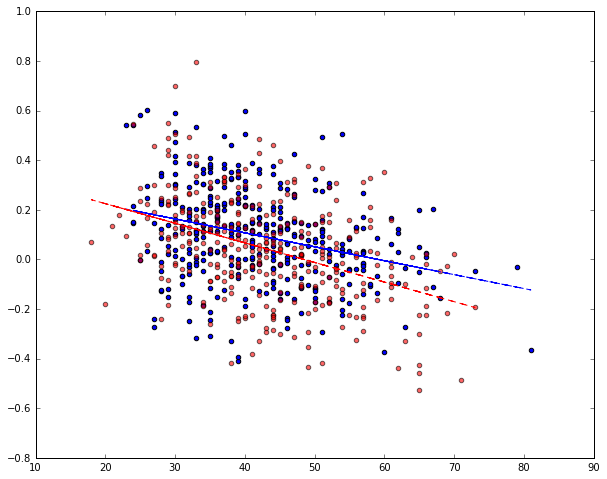

In [63]:
x = reviewed_df.age
y = reviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'b')
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = unreviewed_df.age
y = unreviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'r', alpha = 0.6)
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

The lines are pretty much the same around age 20, but they have different slopes. It appears reviewed authors don't lose resonance as quickly as they age. The mean ages in the two datasets are only slightly different:

In [66]:
np.nanmean(reviewed_df.age)

42.038997214484681

In [67]:
np.nanmean(unreviewed_df.age)

42.991044776119402

But the mean resonance is significantly different.

In [68]:
print(np.nanmean(reviewed_df['resonance_1.0_25']))
print(np.nanmean(unreviewed_df['resonance_1.0_25']))

0.0910516897342
0.019892420356


### However, is that significant?

I have my doubts. Let's compare some other datasets.

#### First, bestsellers.

In [73]:
reviewed_docs = meta.index[meta.best1821_1900 == 1].tolist()
unreviewed_docs = meta.index[meta.best1821_1900contrast == 1].tolist()

reviewed_df = data.loc[reviewed_docs, ['resonance_1.0_25', 'age']]
unreviewed_df = data.loc[unreviewed_docs, ['resonance_1.0_25', 'age']]

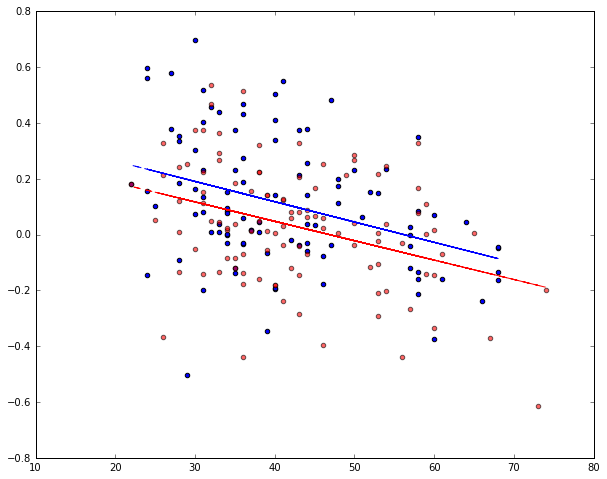

In [74]:
x = reviewed_df.age
y = reviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'b')
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = unreviewed_df.age
y = unreviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'r', alpha = 0.6)
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In that case the lines have the same slope.

#### Now post-65 reviewed books.

In [75]:
reviewed_docs = meta.index[meta.reviewed1965_1990 == 1].tolist()
unreviewed_docs = meta.index[meta.reviewed1965_1990contrast == 1].tolist()

reviewed_df = data.loc[reviewed_docs, ['resonance_1.0_25', 'age']]
unreviewed_df = data.loc[unreviewed_docs, ['resonance_1.0_25', 'age']]

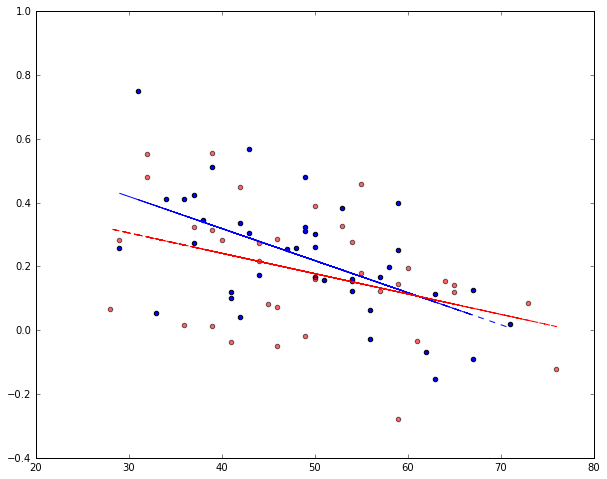

In [76]:
x = reviewed_df.age
y = reviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'b')
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = unreviewed_df.age
y = unreviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'r', alpha = 0.6)
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

So I'm not sure I see any enduring pattern here. It was worth checking, but the only durable pattern is that the red dots are slightly below the blue.

**However**, I should come back and evaluate that after normalizing the resonance scores.

### A methodological example combining matching with regression

I think matching is necessary for this problem because the vast mass of our data contains several kinds of contamination that are not present in our hand-selected lists of canonical, reviewed, etc. volumes.

There's a significant fraction of nonfiction and juvenile fiction, as well as miscellanies, folktales, etc. Some of these things (e.g. the juvenile fiction or folktales) could well register as "old-fashioned" and give a randomly-selected set of volumes a backward bias that would make our hand-selected hypothesis sets seem artificially forward-looking by contrast. Plus, randomly-selected volumes are often (say 13% of the time) reprints, dated later than the real first date of publication. This could create the same sort of bias.

To resolve this, I've created a set of about ~1200 volumes that are manually dated and groomed to exclude most nonfiction and juvenile fiction. Within that set, I select "contrast sets" that try to match the date distribution and us/nonus balance of the hypothesis set, by matching each volume to another with the same values. I think that process excludes a whole host of nasty confounding variables that aren't explicitly marked as such.

However, once we've got a matched dataset, we can still use regression to control for confounding variables that *are* explicitly marked. An example of that process follows.


In [77]:
# first we add a resonance column to the metadata

meta = meta.join(data['resonance_1.0_25'], how = 'inner')
meta.shape

(39784, 40)

In [121]:
# then we select just the rows that belong to the the hypothesis and contrast set

test_df = meta.loc[(meta.reviewed1850_1950 == 1) | (meta.reviewed1850_1950contrast == 1),
                   ['age', 'resonance_1.0_25', 'reviewed1850_1950', 'isusa', 'likelygender', 'latestcomp']]
test_df.head()

,age,resonance_1.0_25,reviewed1850_1950,isusa,likelygender,latestcomp
docid,,,,,,
uc2.ark+=13960=t9m32tr6b,NaN,0.063422,0,0,m,1890
uc1.$b312400,NaN,0.252878,1,0,f,1930
njp.32101068971058,36.0,0.133490,0,0,f,1860
umn.31951002457287u,57.0,0.034402,1,1,m,1893
mdp.39015028550013,45.0,-0.162356,0,0,m,1926


In order to use gender in our regression, we'll need to convert it to a number.

In [122]:
def womentoones(alphabeticgender):
    if pd.isnull(alphabeticgender):
        return 0.5
    elif alphabeticgender == 'f':
        return 1
    else:
        return 0
        
test_df = test_df.assign(gender = test_df.likelygender.map(womentoones))

In [123]:
print(test_df.shape)
print("Reviewed missing age: ", sum(pd.isnull(test_df.age[test_df.reviewed1850_1950 == 1])))
print("Unreviewed missing age: ", sum(pd.isnull(test_df.age[test_df.reviewed1850_1950 == 0])))

(1144, 7)
Reviewed missing age:  182
Unreviewed missing age:  268


Almost half the rows in the DataFrame have no age listed. Stata may handle missing data well, but I'm not confident that Python statsmodels does, so I'm going to kludge and fill those rows with the mean age.

In [124]:
df = test_df.copy(deep = True)
meanage = np.nanmean(df.age)
print(meanage)
for idx in df.index:
    if pd.isnull(df.loc[idx, 'age']):
        df.loc[idx, 'age'] = meanage
df.head()

42.4985590778


,age,resonance_1.0_25,reviewed1850_1950,isusa,likelygender,latestcomp,gender
docid,,,,,,,
uc2.ark+=13960=t9m32tr6b,42.498559,0.063422,0,0,m,1890,0.0
uc1.$b312400,42.498559,0.252878,1,0,f,1930,1.0
njp.32101068971058,36.000000,0.133490,0,0,f,1860,1.0
umn.31951002457287u,57.000000,0.034402,1,1,m,1893,0.0
mdp.39015028550013,45.000000,-0.162356,0,0,m,1926,0.0


#### Create a special variable to compensate for the n-shaped warping of topic models.

In [127]:
df = df.assign(npeak = np.absolute(df.latestcomp - np.mean(df.latestcomp)))
df.head()

,age,resonance_1.0_25,reviewed1850_1950,isusa,likelygender,latestcomp,gender,npeak
docid,,,,,,,,
uc2.ark+=13960=t9m32tr6b,42.498559,0.063422,0,0,m,1890,0.0,6.232517
uc1.$b312400,42.498559,0.252878,1,0,f,1930,1.0,33.767483
njp.32101068971058,36.000000,0.133490,0,0,f,1860,1.0,36.232517
umn.31951002457287u,57.000000,0.034402,1,1,m,1893,0.0,3.232517
mdp.39015028550013,45.000000,-0.162356,0,0,m,1926,0.0,29.767483


In [128]:
y = df.loc[ : , 'resonance_1.0_25']
X = df.loc[: , ['age', 'reviewed1850_1950', 'isusa', 'gender', 'latestcomp', 'npeak']]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       resonance_1.0_25   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     73.27
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           2.44e-77
Time:                        09:51:47   Log-Likelihood:                 361.48
No. Observations:                1144   AIC:                            -711.0
Df Residuals:                    1138   BIC:                            -680.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0063      0.00

#### The upshot:

Our hypothesis condition (being reviewed) has a strong effect. Age, nationality, and date of composition also have strongly significant coefficients. Gender does not.

*Notice that npeak is the most powerful of all these factors.*

### One more regression, to evaluate the power of canonicity

Let's try folding together the US Norton and non-US Norton sets (and their respective contrast sets) to get a general evaluation of the power of canonicity. We'll include ```age, isusa,``` and latest-possible-date-of-composition (```latestcomp```) as control variables.

In [129]:
test_df = meta.loc[(meta.usnorton == 1) | 
                   (meta.usnortoncontrast == 1) |
                   (meta.nonusnorton == 1) |
                   (meta.nonusnortoncontrast == 1), 
                   ['age', 'resonance_1.0_25', 'usnorton', 'nonusnorton', 'isusa', 'latestcomp']]
test_df.head()

,age,resonance_1.0_25,usnorton,nonusnorton,isusa,latestcomp
docid,,,,,,
uc1.32106010927223,NaN,NaN,1,0,1,1989
nyp.33433074943634,38.0,NaN,0,1,0,1813
njp.32101068171212,59.0,0.001034,0,0,0,1851
"miun.abr7583,0001,001",NaN,0.152065,1,0,1,1924
uc2.ark+=13960=t16m33f86,41.0,0.148111,0,0,0,1874


#### general canonicity

Create a column that reflects whether the volume is from a Norton (US *or* not).

In [130]:
def whether_norton(row):
    if row.usnorton == 1 or row.nonusnorton == 1:
        return 1
    else:
        return 0

test_df = test_df.assign(norton = test_df.apply(whether_norton, axis = 1))

In [131]:
df = test_df.copy(deep = True)
meanage = np.nanmean(df.age)
print(meanage)
for idx in df.index:
    if pd.isnull(df.loc[idx, 'age']):
        df.loc[idx, 'age'] = meanage
df.head()

44.9130434783


,age,resonance_1.0_25,usnorton,nonusnorton,isusa,latestcomp,norton
docid,,,,,,,
uc1.32106010927223,44.913043,NaN,1,0,1,1989,1
nyp.33433074943634,38.000000,NaN,0,1,0,1813,1
njp.32101068171212,59.000000,0.001034,0,0,0,1851,0
"miun.abr7583,0001,001",44.913043,0.152065,1,0,1,1924,1
uc2.ark+=13960=t16m33f86,41.000000,0.148111,0,0,0,1874,0


Let's drop rows that are too near the edge of the timeline for the 25-year resonance to be calculated.

In [132]:
# still need to dropna
print(df.shape)
df.dropna(inplace = True)
print(df.shape)

(225, 7)
(203, 7)


#### Create a variable to compensate for n-shaped warping

In [133]:
df = df.assign(npeak = np.absolute(df.latestcomp - np.mean(df.latestcomp)))
df.head()

,age,resonance_1.0_25,usnorton,nonusnorton,isusa,latestcomp,norton,npeak
docid,,,,,,,,
njp.32101068171212,59.000000,0.001034,0,0,0,1851,0,51.172414
"miun.abr7583,0001,001",44.913043,0.152065,1,0,1,1924,1,21.827586
uc2.ark+=13960=t16m33f86,41.000000,0.148111,0,0,0,1874,0,28.172414
nyp.33433074954169,27.000000,0.323087,0,1,0,1839,1,63.172414
uiuo.ark+=13960=t3nv9vv41,44.000000,0.096754,0,0,0,1849,0,53.172414


Now we'll try a regression that evaluates the general power of *Nortonicity.*

In [134]:
y = df.loc[ : , 'resonance_1.0_25']
X = df.loc[: , ['age', 'norton', 'isusa', 'latestcomp', 'npeak']]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       resonance_1.0_25   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     19.82
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           5.35e-16
Time:                        09:53:28   Log-Likelihood:                 65.282
No. Observations:                 203   AIC:                            -120.6
Df Residuals:                     198   BIC:                            -104.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0065      0.001     -6.102      0.0

#### When the two sets are folded together, Nortonicity is significant, but

when they're broken apart, only nonusnorton is significant.

In [135]:
y = df.loc[ : , 'resonance_1.0_25']
X = df.loc[: , ['age', 'usnorton', 'nonusnorton', 'isusa', 'latestcomp', 'npeak']]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       resonance_1.0_25   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           1.32e-15
Time:                        09:53:50   Log-Likelihood:                 65.981
No. Observations:                 203   AIC:                            -120.0
Df Residuals:                     197   BIC:                            -100.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
age            -0.0064      0.001     -6.010      